/tmp/ipython-input-2-2994795768.py:61: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  dfg["Holiday"] = dfg["Date"].isin(uae_hols).astype(int)
/tmp/ipython-input-2-2994795768.py:62: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  dfg["Pre_Holiday"] = dfg["Date"].shift(-1).isin(uae_hols).astype(int)
/tmp/ipython-input-2-2994795768.py:63: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instea

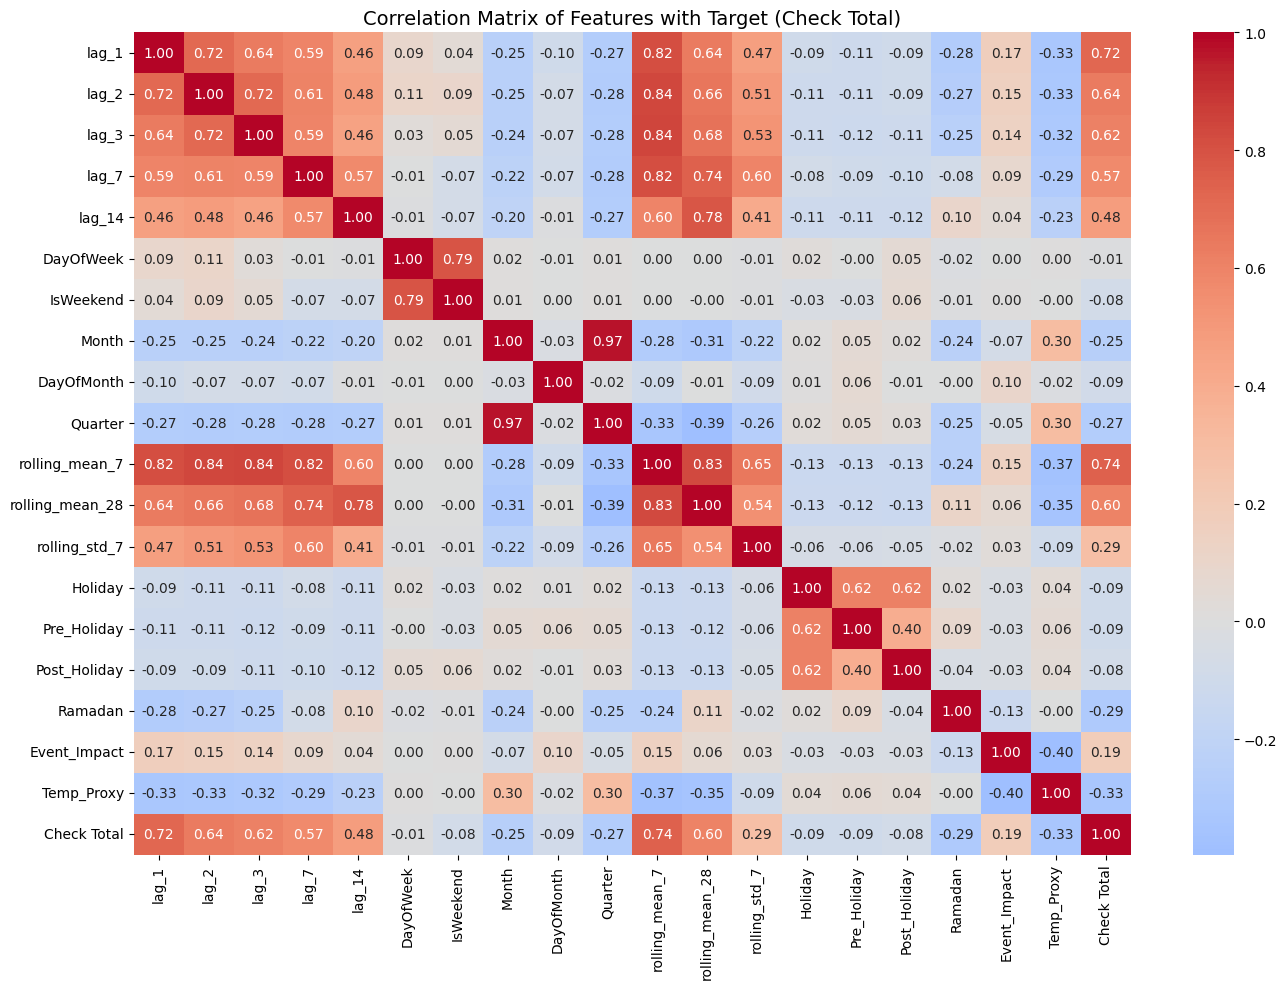

[0]	train-rmse:5031.47312	validation-rmse:12333.40382
[50]	train-rmse:1470.45126	validation-rmse:8786.39130
[55]	train-rmse:1413.79468	validation-rmse:8828.27035


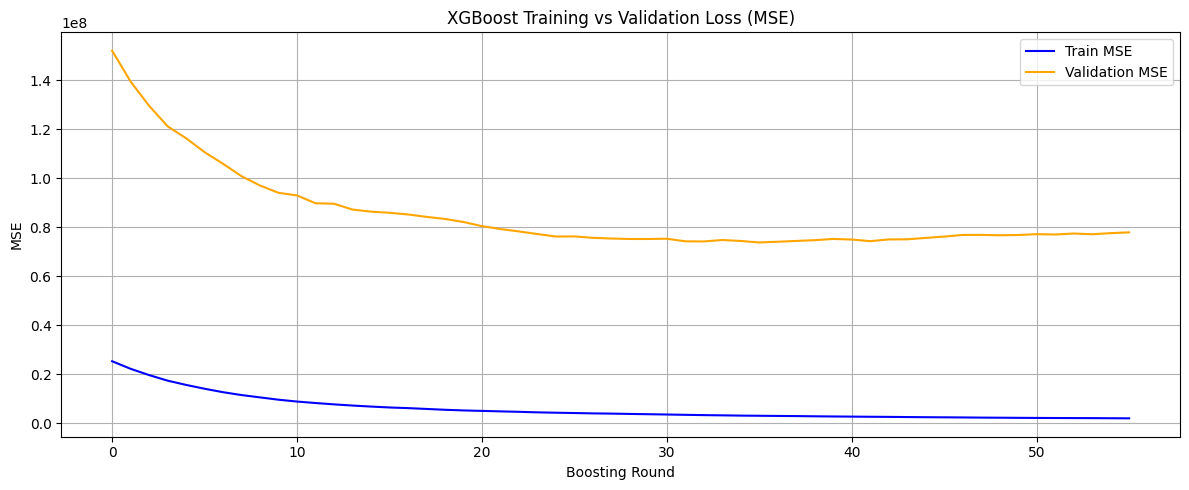


Validation Metrics for RevenueCenter_3:
  RMSE: 8828.27
   MAE: 4769.60
  MAPE: 34.27%


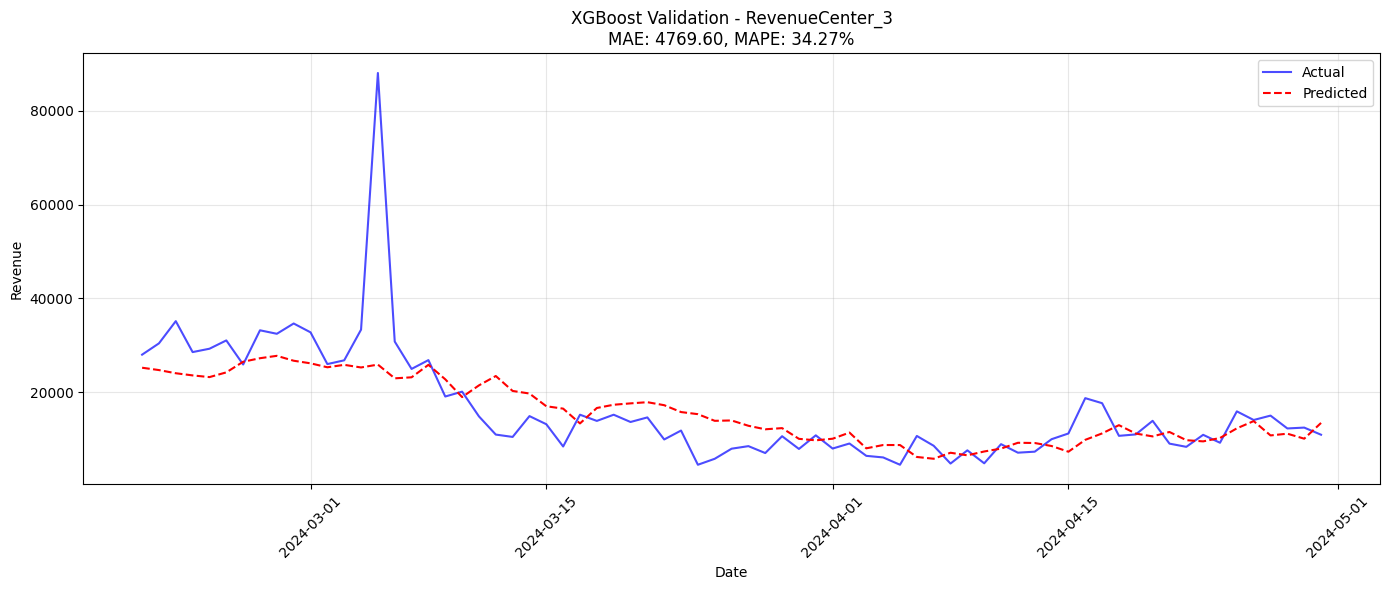

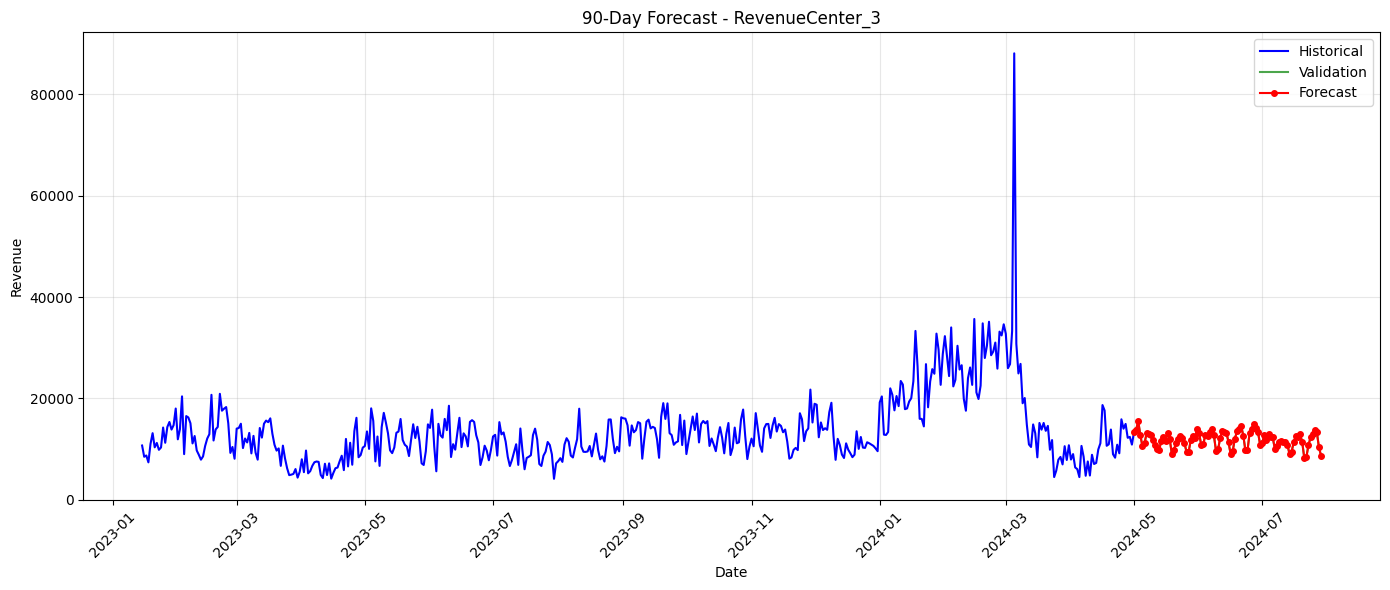


Residual Analysis:
Mean Residual: 739.82
Residual Std Dev: 8797.22


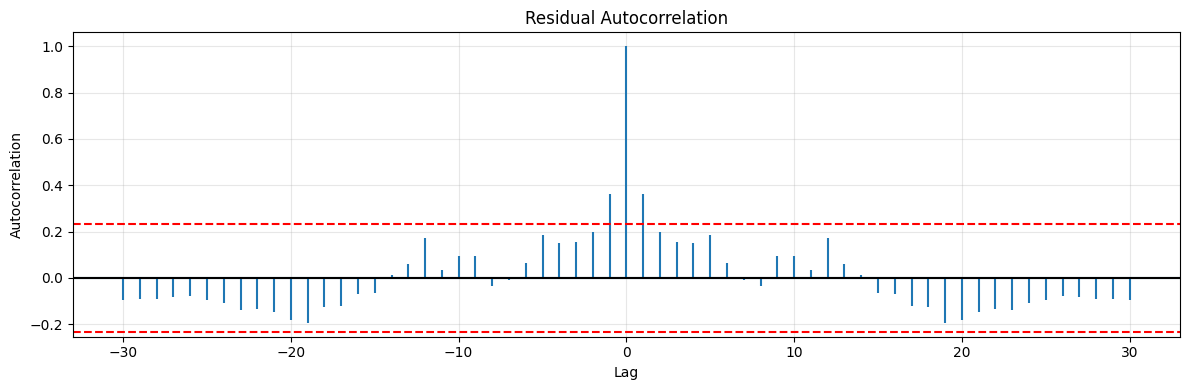

In [2]:
!pip install hijri-converter holidays  # Install required packages
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from datetime import timedelta
import holidays
from hijri_converter import convert

# --- CONFIG ---
DATA_PATH = "/content/Hotel_Revenue_Data.xlsx"
CENTER = "RevenueCenter_3"
TEST_RATIO = 0.15
HISTORY_WINDOW = 365  # Use 1-year lookback for features

# Optimized lag structure for hotel revenue
LAGS = [1, 2, 3, 7, 14]  # Key intervals for hotel revenue patterns

# --- LOAD DATA ---
df = pd.read_excel(DATA_PATH, parse_dates=["Date"])
df.rename(columns={
    "MealPeriod": "Meal Period",
    "CheckTotal": "Check Total",
    "RevenueCenterName": "Revenue Center"
}, inplace=True)

# --- FILTER & AGGREGATE ---
dfc = df[df["Revenue Center"] == CENTER]
dfg = dfc.groupby("Date")["Check Total"].sum().reset_index()

# Create complete date range and fill missing values
full_date_range = pd.date_range(start=dfg["Date"].min(), end=dfg["Date"].max(), freq="D")
dfg = dfg.set_index("Date").reindex(full_date_range).rename_axis("Date").reset_index()

# Fill missing values with day-of-week averages
dow_avg = dfg.groupby(dfg["Date"].dt.dayofweek)["Check Total"].mean()
dfg["dow_avg"] = dfg["Date"].dt.dayofweek.map(dow_avg)
dfg["Check Total"] = dfg["Check Total"].fillna(dfg["dow_avg"])
dfg.drop(columns="dow_avg", inplace=True)

# --- ENHANCED FEATURE ENGINEERING ---
dfg["DayOfWeek"] = dfg["Date"].dt.dayofweek
dfg["IsWeekend"] = dfg["DayOfWeek"].isin([5,6]).astype(int)
dfg["Month"] = dfg["Date"].dt.month
dfg["DayOfMonth"] = dfg["Date"].dt.day
dfg["Quarter"] = dfg["Date"].dt.quarter

# Lag features - prevent leakage with shift
for lag in LAGS:
    dfg[f"lag_{lag}"] = dfg["Check Total"].shift(lag)

# Rolling features - shifted to prevent leakage
dfg["rolling_mean_7"] = dfg["Check Total"].shift(1).rolling(7).mean()
dfg["rolling_mean_28"] = dfg["Check Total"].shift(1).rolling(28).mean()
dfg["rolling_std_7"] = dfg["Check Total"].shift(1).rolling(7).std().fillna(0)

# UAE Holidays
uae_hols = holidays.country_holidays("AE", years=range(2010, 2025))
dfg["Holiday"] = dfg["Date"].isin(uae_hols).astype(int)
dfg["Pre_Holiday"] = dfg["Date"].shift(-1).isin(uae_hols).astype(int)
dfg["Post_Holiday"] = dfg["Date"].shift(1).isin(uae_hols).astype(int)

# Dubai Event Calendar (Example - extend with your actual events)
events = {
    "Dubai_Shopping_Festival": pd.date_range("2023-12-15", "2024-01-31"),
    "GITEX_Global": pd.date_range("2024-10-13", "2024-10-17"),
    "Arabian_Travel_Market": pd.date_range("2024-05-06", "2024-05-09"),
    "Dubai_Food_Festival": pd.date_range("2024-05-02", "2024-05-12")
}
dfg["Event_Impact"] = 1.0  # Default multiplier
for event, dates in events.items():
    dfg.loc[dfg["Date"].isin(dates), "Event_Impact"] = 1.5  # 50% boost during events

# Ramadan Feature (Critical for Dubai)
def get_ramadan_flag(date):
    try:
        hijri = convert.Gregorian(date.year, date.month, date.day).to_hijri()
        return 1 if hijri.month == 9 else 0
    except:
        return 0  # Fallback for date conversion errors

dfg["Ramadan"] = dfg["Date"].apply(get_ramadan_flag)

# Weather proxy (Dubai-specific temperature patterns)
def dubai_temp(date):
    """Simplified temperature model for Dubai (scaled 0-1)"""
    month = date.month
    if month in [6,7,8]:  # Summer peak
        return 0.9
    elif month in [12,1,2]:  # Winter
        return 0.4
    else:  # Shoulder seasons
        return 0.6

dfg["Temp_Proxy"] = dfg["Date"].apply(dubai_temp)

# Drop initial rows with missing lag values
dfg = dfg.dropna(subset=[f"lag_{max(LAGS)}"]).reset_index(drop=True)

# --- TRAIN/VALID SPLIT ---
FEATURES = [
    f"lag_{lag}" for lag in LAGS
] + [
    "DayOfWeek", "IsWeekend", "Month", "DayOfMonth", "Quarter",
    "rolling_mean_7", "rolling_mean_28", "rolling_std_7",
    "Holiday", "Pre_Holiday", "Post_Holiday",
    "Ramadan", "Event_Impact", "Temp_Proxy"
]

TARGET = "Check Total"

import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns used for modeling
corr_features = FEATURES + [TARGET]
corr_matrix = dfg[corr_features].corr()

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Matrix of Features with Target (Check Total)", fontsize=14)
plt.tight_layout()
plt.show()


split_idx = int((1 - TEST_RATIO) * len(dfg))
train_df = dfg.iloc[:split_idx]
valid_df = dfg.iloc[split_idx:]

X_train, y_train = train_df[FEATURES].values, train_df[TARGET].values
X_val, y_val = valid_df[FEATURES].values, valid_df[TARGET].values

# --- MODEL TRAINING WITH OPTIMIZED PARAMETERS ---
params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "max_depth": 8,
    "eta": 0.1,
    "subsample": 0.8,
    "colsample_bytree": 0.7,
    "gamma": 0.5,
    "min_child_weight": 10,
    "alpha": 0.5,  # L1 regularization
    "lambda": 1.0,  # L2 regularization
    "seed": 42
}

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=FEATURES)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=FEATURES)

evals = [(dtrain, "train"), (dval, "validation")]
evals_result = {}
model = xgb.train(
    params,
    dtrain,
    num_boost_round=500,
    evals=evals,
    early_stopping_rounds=20,
    evals_result=evals_result,
    verbose_eval=50
)

# --- PLOT TRAINING vs VALIDATION MSE LOSS ---
train_rmse = np.array(evals_result["train"]["rmse"])
val_rmse = np.array(evals_result["validation"]["rmse"])

train_mse = train_rmse ** 2
val_mse = val_rmse ** 2

plt.figure(figsize=(12, 5))
plt.plot(train_mse, label="Train MSE", color='blue')
plt.plot(val_mse, label="Validation MSE", color='orange')
plt.title("XGBoost Training vs Validation Loss (MSE)")
plt.xlabel("Boosting Round")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# --- EVALUATION ---
y_pred = model.predict(dval)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)
mape = np.mean(np.abs((y_val - y_pred) / np.maximum(y_val, 1))) * 100  # Avoid division by zero

print(f"\nValidation Metrics for {CENTER}:")
print(f"  RMSE: {rmse:.2f}")
print(f"   MAE: {mae:.2f}")
print(f"  MAPE: {mape:.2f}%")

# --- VISUALIZATION ---
plt.figure(figsize=(14, 6))
plt.plot(valid_df["Date"], y_val, "b-", label="Actual", alpha=0.7)
plt.plot(valid_df["Date"], y_pred, "r--", label="Predicted", linewidth=1.5)
plt.title(f"XGBoost Validation - {CENTER}\nMAE: {mae:.2f}, MAPE: {mape:.2f}%")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- FORECAST NEXT 90 DAYS WITH ENSEMBLE ---
full_history = dfg.copy().set_index("Date")["Check Total"]
future_dates = pd.date_range(dfg["Date"].iloc[-1] + timedelta(days=1), periods=90, freq="D")
forecast_values = []

for date in future_dates:
    # Prepare features
    features = {}

    # Date-based features
    features["DayOfWeek"] = date.dayofweek
    features["IsWeekend"] = 1 if date.dayofweek >= 5 else 0
    features["Month"] = date.month
    features["DayOfMonth"] = date.day
    features["Quarter"] = (date.month - 1) // 3 + 1
    features["Holiday"] = 1 if date in uae_hols else 0
    features["Pre_Holiday"] = 1 if (date + timedelta(days=1)) in uae_hols else 0
    features["Post_Holiday"] = 1 if (date - timedelta(days=1)) in uae_hols else 0
    features["Ramadan"] = get_ramadan_flag(date)
    features["Temp_Proxy"] = dubai_temp(date)

    # Event impact
    features["Event_Impact"] = 1.0
    for event, dates in events.items():
        if date in dates:
            features["Event_Impact"] = 1.5

    # Lag features using recent history
    for lag in LAGS:
        lag_date = date - timedelta(days=lag)
        features[f"lag_{lag}"] = full_history.get(lag_date, full_history.iloc[-lag])

    # Rolling features (using last available data)
    features["rolling_mean_7"] = full_history.iloc[-7:].mean()
    features["rolling_mean_28"] = full_history.iloc[-28:].mean()
    features["rolling_std_7"] = full_history.iloc[-7:].std()

    # Create feature array in correct order
    feature_array = np.array([features[col] for col in FEATURES]).reshape(1, -1)

    # Ensemble prediction (5 samples)
    predictions = []
    for _ in range(5):
        dmat = xgb.DMatrix(feature_array, feature_names=FEATURES)
        predictions.append(model.predict(dmat)[0])

    # Trimmed mean to reduce outliers
    predictions_sorted = sorted(predictions)
    predicted_revenue = np.mean(predictions_sorted[1:-1])

    # Update history with prediction
    full_history.loc[date] = predicted_revenue
    forecast_values.append(predicted_revenue)

# --- PLOT FORECAST ---
plt.figure(figsize=(14, 6))
history_end = full_history.index[-90]  # Last historical date
plt.plot(full_history.loc[:history_end], "b-", label="Historical")
plt.plot(full_history.loc[history_end:], "g-", label="Validation", alpha=0.7)
plt.plot(future_dates, forecast_values, "r-", marker="o", markersize=4, label="Forecast")
plt.title(f"90-Day Forecast - {CENTER}")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- RESIDUAL ANALYSIS ---
residuals = y_val - y_pred
print("\nResidual Analysis:")
print(f"Mean Residual: {residuals.mean():.2f}")
print(f"Residual Std Dev: {residuals.std():.2f}")

# Residual Autocorrelation Plot
plt.figure(figsize=(12, 4))
plt.acorr(residuals, maxlags=30, usevlines=True, normed=True)
plt.axhline(y=0, color="black")
plt.axhline(y=1.96/np.sqrt(len(residuals)), color="red", linestyle="--")
plt.axhline(y=-1.96/np.sqrt(len(residuals)), color="red", linestyle="--")
plt.title("Residual Autocorrelation")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Check if we need hybrid modeling
if mape > 15 or abs(residuals.autocorr(lag=7)) > 0.2:
    print("\nWARNING: Significant residuals detected - consider hybrid SARIMA approach")

[0]	train-mae:250.59250	train-rmse:363.71121	validation-mae:422.38173	validation-rmse:948.68233
[28]	train-mae:158.92233	train-rmse:235.01061	validation-mae:482.45449	validation-rmse:934.79797


/tmp/ipython-input-1-1832675270.py:58: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  dfg["Holiday"] = dfg["Date"].isin(uae_hols).astype(int)
/tmp/ipython-input-1-1832675270.py:59: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  dfg["Pre_Holiday"] = dfg["Date"].shift(-1).isin(uae_hols).astype(int)
/tmp/ipython-input-1-1832675270.py:60: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instea

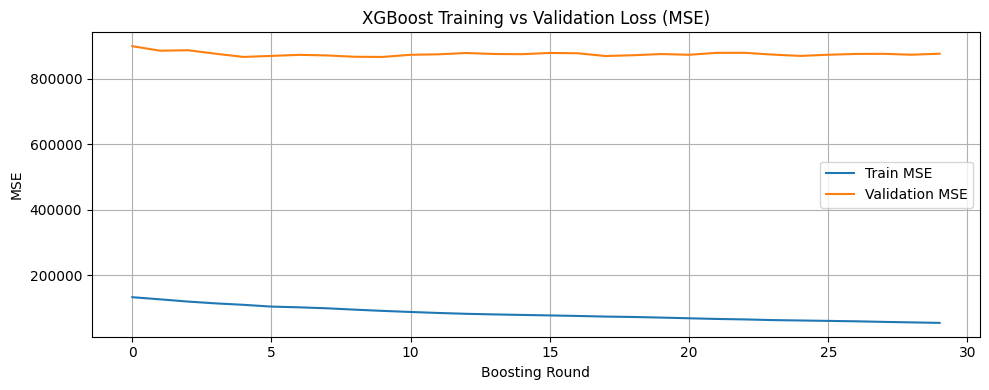


Validation Metrics for RevenueCenter_2 - Lunch:
  RMSE: 936.46
   MAE: 483.16


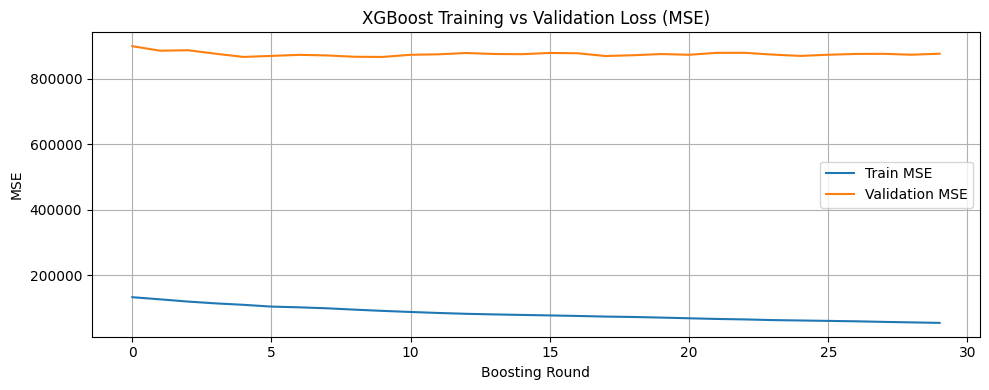

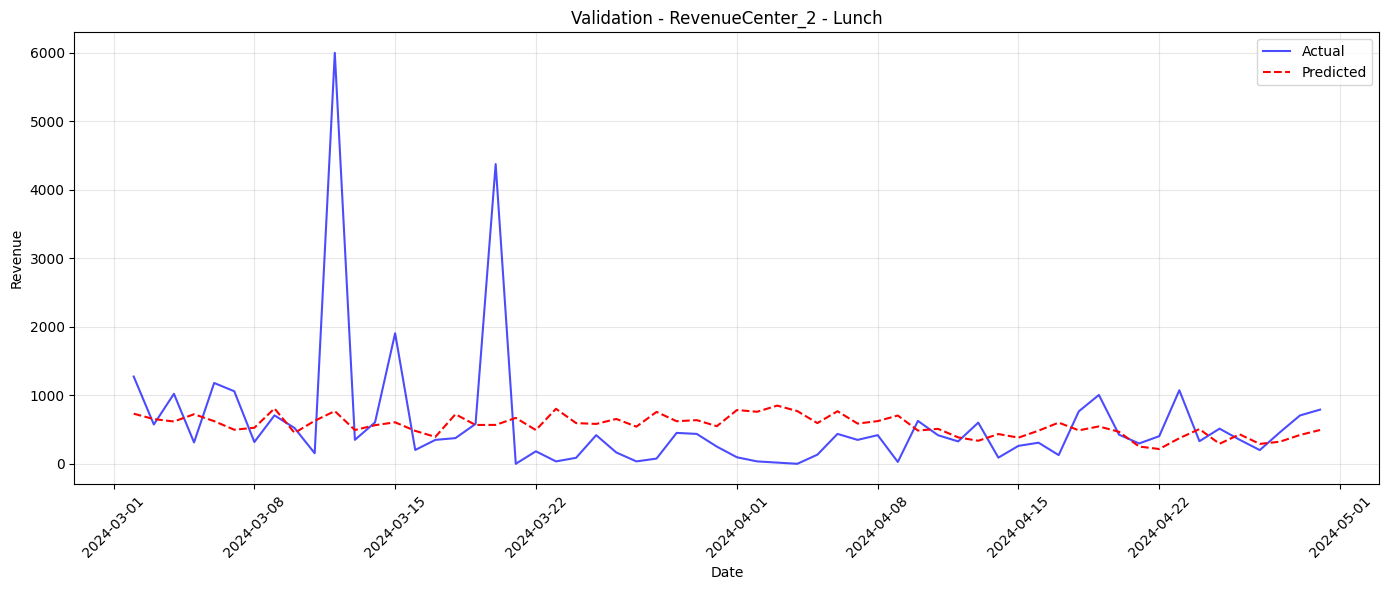

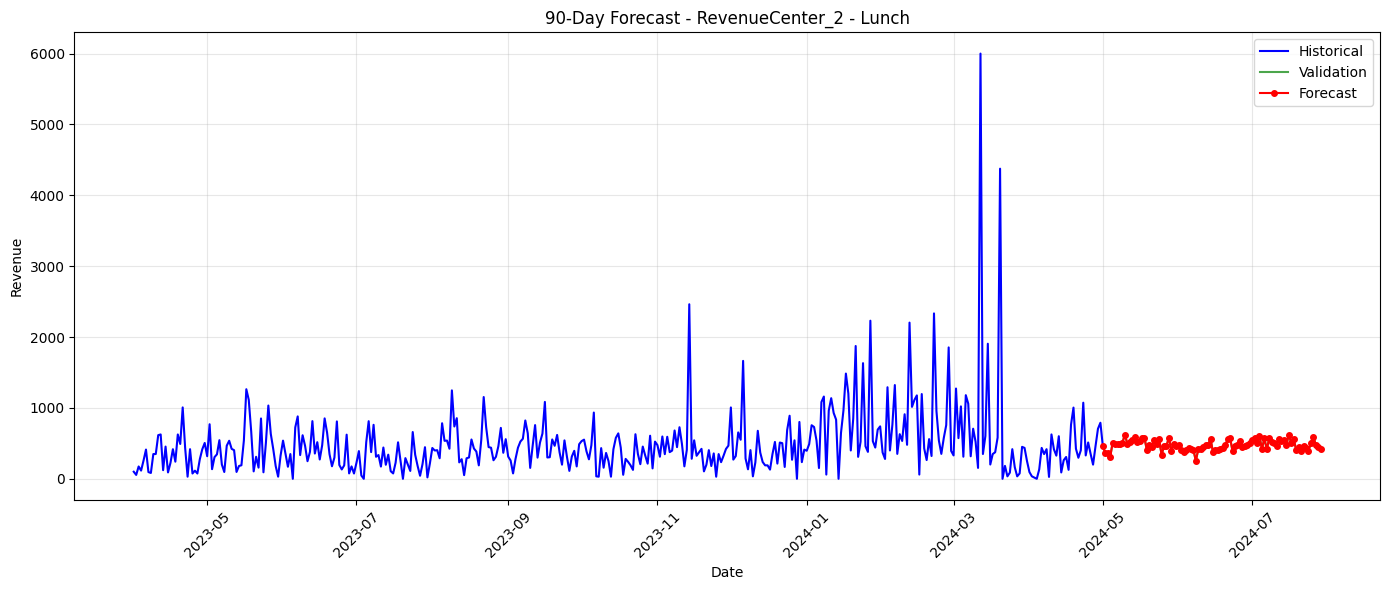

In [1]:
!pip install hijri-converter holidays  # Install required packages

import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from datetime import timedelta
import holidays
from hijri_converter import convert

# --- CONFIG ---
DATA_PATH = "/content/Hotel_Revenue_Data.xlsx"
CENTER = "RevenueCenter_2"      # <<< Change as needed
MEAL_PERIOD = "Lunch"       # <<< Change as needed
TEST_RATIO = 0.15
HISTORY_WINDOW = 365
LAGS = [1, 2, 3, 7, 14, 28, 35, 60, 90]

# --- LOAD & FILTER DATA ---
df = pd.read_excel(DATA_PATH, parse_dates=["Date"])
df.rename(columns={
    "MealPeriod": "Meal Period",
    "CheckTotal": "Check Total",
    "RevenueCenterName": "Revenue Center"
}, inplace=True)

# Filter for Revenue Center and Meal Period
df_filtered = df[(df["Revenue Center"] == CENTER) & (df["Meal Period"] == MEAL_PERIOD)]
dfg = df_filtered.groupby("Date")["Check Total"].sum().reset_index()

# Complete date range
full_date_range = pd.date_range(start=dfg["Date"].min(), end=dfg["Date"].max(), freq="D")
dfg = dfg.set_index("Date").reindex(full_date_range).rename_axis("Date").reset_index()

# Fill missing values with day-of-week average
dow_avg = dfg.groupby(dfg["Date"].dt.dayofweek)["Check Total"].mean()
dfg["dow_avg"] = dfg["Date"].dt.dayofweek.map(dow_avg)
dfg["Check Total"] = dfg["Check Total"].fillna(dfg["dow_avg"])
dfg.drop(columns="dow_avg", inplace=True)

# --- FEATURE ENGINEERING ---
dfg["DayOfWeek"] = dfg["Date"].dt.dayofweek
dfg["IsWeekend"] = dfg["DayOfWeek"].isin([5, 6]).astype(int)
dfg["Month"] = dfg["Date"].dt.month
dfg["DayOfMonth"] = dfg["Date"].dt.day
dfg["Quarter"] = dfg["Date"].dt.quarter

for lag in LAGS:
    dfg[f"lag_{lag}"] = dfg["Check Total"].shift(lag)

dfg["rolling_mean_7"] = dfg["Check Total"].shift(1).rolling(7).mean()
dfg["rolling_mean_28"] = dfg["Check Total"].shift(1).rolling(28).mean()
dfg["rolling_std_7"] = dfg["Check Total"].shift(1).rolling(7).std().fillna(0)

uae_hols = holidays.country_holidays("AE", years=range(2010, 2025))
dfg["Holiday"] = dfg["Date"].isin(uae_hols).astype(int)
dfg["Pre_Holiday"] = dfg["Date"].shift(-1).isin(uae_hols).astype(int)
dfg["Post_Holiday"] = dfg["Date"].shift(1).isin(uae_hols).astype(int)

events = {
    "Dubai_Shopping_Festival": pd.date_range("2023-12-15", "2024-01-31"),
    "GITEX_Global": pd.date_range("2024-10-13", "2024-10-17"),
    "Arabian_Travel_Market": pd.date_range("2024-05-06", "2024-05-09"),
    "Dubai_Food_Festival": pd.date_range("2024-05-02", "2024-05-12")
}
dfg["Event_Impact"] = 1.0
for event, dates in events.items():
    dfg.loc[dfg["Date"].isin(dates), "Event_Impact"] = 1.5

def get_ramadan_flag(date):
    try:
        hijri = convert.Gregorian(date.year, date.month, date.day).to_hijri()
        return 1 if hijri.month == 9 else 0
    except:
        return 0

dfg["Ramadan"] = dfg["Date"].apply(get_ramadan_flag)

def dubai_temp(date):
    month = date.month
    if month in [6, 7, 8]:
        return 0.9
    elif month in [12, 1, 2]:
        return 0.4
    else:
        return 0.6

dfg["Temp_Proxy"] = dfg["Date"].apply(dubai_temp)
dfg = dfg.dropna(subset=[f"lag_{max(LAGS)}"]).reset_index(drop=True)

# --- TRAIN/VALID SPLIT ---
FEATURES = [f"lag_{lag}" for lag in LAGS] + [
    "DayOfWeek", "IsWeekend", "Month", "DayOfMonth", "Quarter",
    "rolling_mean_7", "rolling_mean_28", "rolling_std_7",
    "Holiday", "Pre_Holiday", "Post_Holiday",
    "Ramadan", "Event_Impact", "Temp_Proxy"
]
TARGET = "Check Total"

split_idx = int((1 - TEST_RATIO) * len(dfg))
train_df, valid_df = dfg.iloc[:split_idx], dfg.iloc[split_idx:]

X_train, y_train = train_df[FEATURES].values, train_df[TARGET].values
X_val, y_val = valid_df[FEATURES].values, valid_df[TARGET].values

# --- MODEL TRAINING ---
params = {
    "objective": "reg:squarederror",
    "eval_metric": ["mae", "rmse"],
    "max_depth": 8,
    "eta": 0.1,
    "subsample": 0.7,
    "colsample_bytree": 0.6,
    "gamma": 0.5,
    "min_child_weight": 10,
    "alpha": 1.0,
    "lambda": 2.0,
    "seed": 42
}

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=FEATURES)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=FEATURES)
evals = [(dtrain, "train"), (dval, "validation")]

evals_result = {}


model = xgb.train(
    params,
    dtrain,
    num_boost_round=500,
    evals=evals,
    early_stopping_rounds=20,
    evals_result=evals_result,
    verbose_eval=50
)


# --- PLOT TRAINING AND VALIDATION LOSS ---
plt.figure(figsize=(10, 4))
train_rmse = np.array(evals_result["train"]["rmse"])
val_rmse = np.array(evals_result["validation"]["rmse"])
plt.plot(train_rmse ** 2, label="Train MSE")
plt.plot(val_rmse ** 2, label="Validation MSE")
plt.title("XGBoost Training vs Validation Loss (MSE)")
plt.xlabel("Boosting Round")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- EVALUATION ---
y_pred = model.predict(dval)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)
mape = np.mean(np.abs((y_val - y_pred) / np.maximum(y_val, 1))) * 100

print(f"\nValidation Metrics for {CENTER} - {MEAL_PERIOD}:")
print(f"  RMSE: {rmse:.2f}")
print(f"   MAE: {mae:.2f}")
#print(f"  MAPE: {mape:.2f}%")

plt.figure(figsize=(10, 4))

train_rmse = np.array(evals_result["train"]["rmse"])
val_rmse = np.array(evals_result["validation"]["rmse"])

plt.plot(train_rmse ** 2, label="Train MSE")
plt.plot(val_rmse ** 2, label="Validation MSE")

plt.title("XGBoost Training vs Validation Loss (MSE)")
plt.xlabel("Boosting Round")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
plt.plot(valid_df["Date"], y_val, "b-", label="Actual", alpha=0.7)
plt.plot(valid_df["Date"], y_pred, "r--", label="Predicted", linewidth=1.5)
plt.title(f"Validation - {CENTER} - {MEAL_PERIOD}")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# --- FORECAST NEXT 90 DAYS ---
full_history = dfg.copy().set_index("Date")["Check Total"]
future_dates = pd.date_range(dfg["Date"].iloc[-1] + timedelta(days=1), periods=90, freq="D")
forecast_values = []

for date in future_dates:
    features = {}

    features["DayOfWeek"] = date.dayofweek
    features["IsWeekend"] = 1 if date.dayofweek >= 5 else 0
    features["Month"] = date.month
    features["DayOfMonth"] = date.day
    features["Quarter"] = (date.month - 1) // 3 + 1
    features["Holiday"] = 1 if date in uae_hols else 0
    features["Pre_Holiday"] = 1 if (date + timedelta(days=1)) in uae_hols else 0
    features["Post_Holiday"] = 1 if (date - timedelta(days=1)) in uae_hols else 0
    features["Ramadan"] = get_ramadan_flag(date)
    features["Temp_Proxy"] = dubai_temp(date)

    features["Event_Impact"] = 1.0
    for event, dates in events.items():
        if date in dates:
            features["Event_Impact"] = 1.5

    for lag in LAGS:
        lag_date = date - timedelta(days=lag)
        features[f"lag_{lag}"] = full_history.get(lag_date, full_history.iloc[-lag])

    features["rolling_mean_7"] = full_history.iloc[-7:].mean()
    features["rolling_mean_28"] = full_history.iloc[-28:].mean()
    features["rolling_std_7"] = full_history.iloc[-7:].std()

    feature_array = np.array([features[col] for col in FEATURES]).reshape(1, -1)

    predictions = []
    for _ in range(5):  # ensemble of 5 samples
        dmat = xgb.DMatrix(feature_array, feature_names=FEATURES)
        predictions.append(model.predict(dmat)[0])

    predicted_revenue = np.mean(sorted(predictions)[1:-1])  # trimmed mean
    full_history.loc[date] = predicted_revenue
    forecast_values.append(predicted_revenue)

# --- PLOT FORECAST ---
plt.figure(figsize=(14, 6))
history_end = full_history.index[-90]
plt.plot(full_history.loc[:history_end], "b-", label="Historical")
plt.plot(full_history.loc[history_end:], "g-", label="Validation", alpha=0.7)
plt.plot(future_dates, forecast_values, "r-", marker="o", markersize=4, label="Forecast")
plt.title(f"90-Day Forecast - {CENTER} - {MEAL_PERIOD}")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


RevenueCenter_1 - Dinner | MAE: 1810.20, MAPE: 121.59%


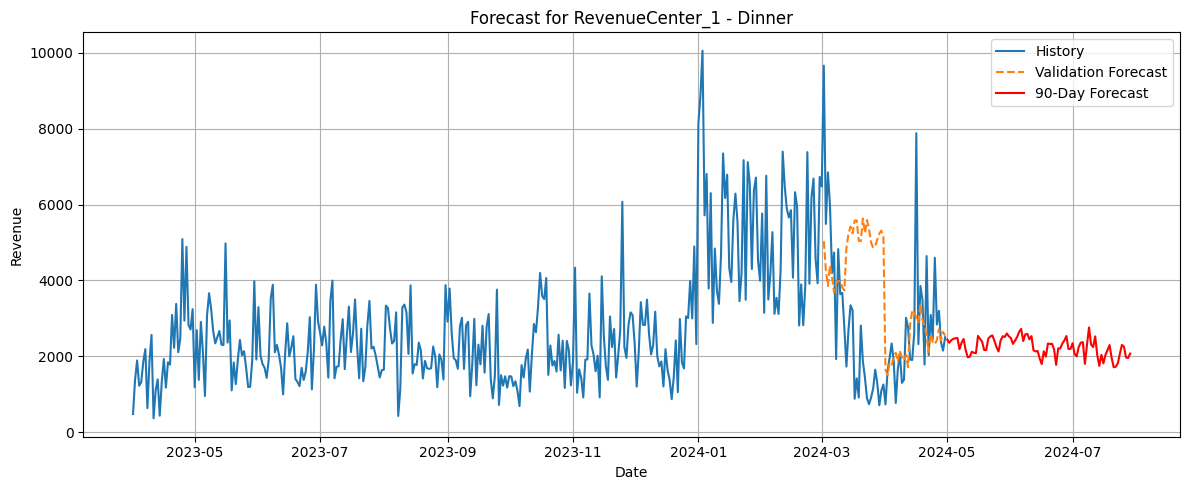

RevenueCenter_1 - Lunch | MAE: 517.62, MAPE: 148.71%


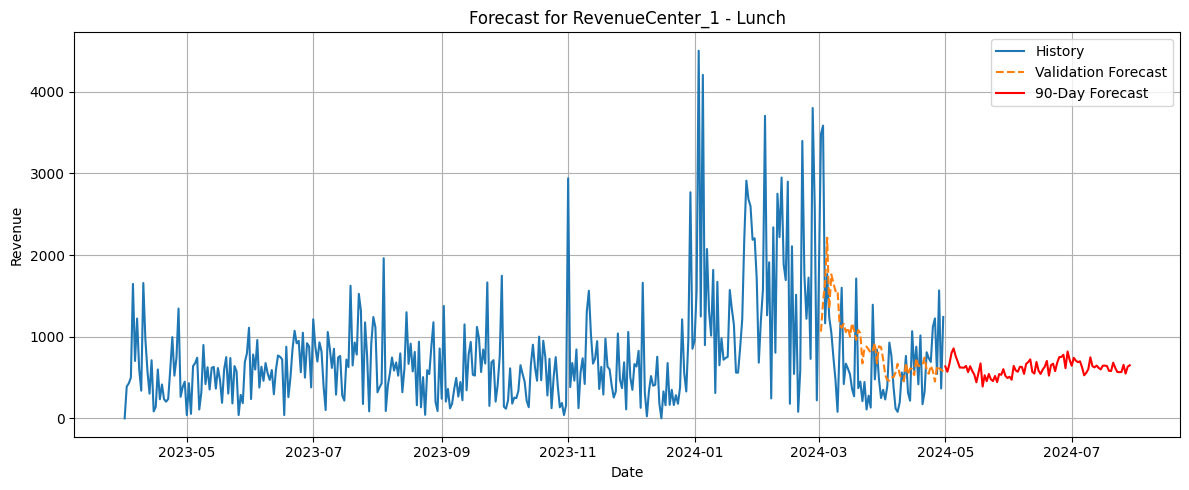

RevenueCenter_1 - BreakFast | MAE: 883.32, MAPE: 2697.12%


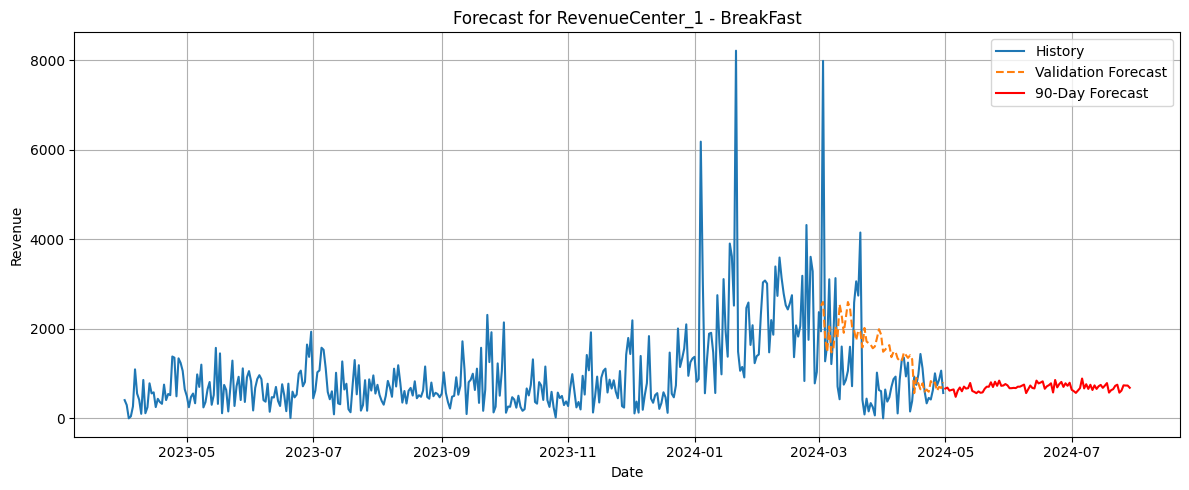

RevenueCenter_2 - Dinner | MAE: 501.28, MAPE: 1551.32%


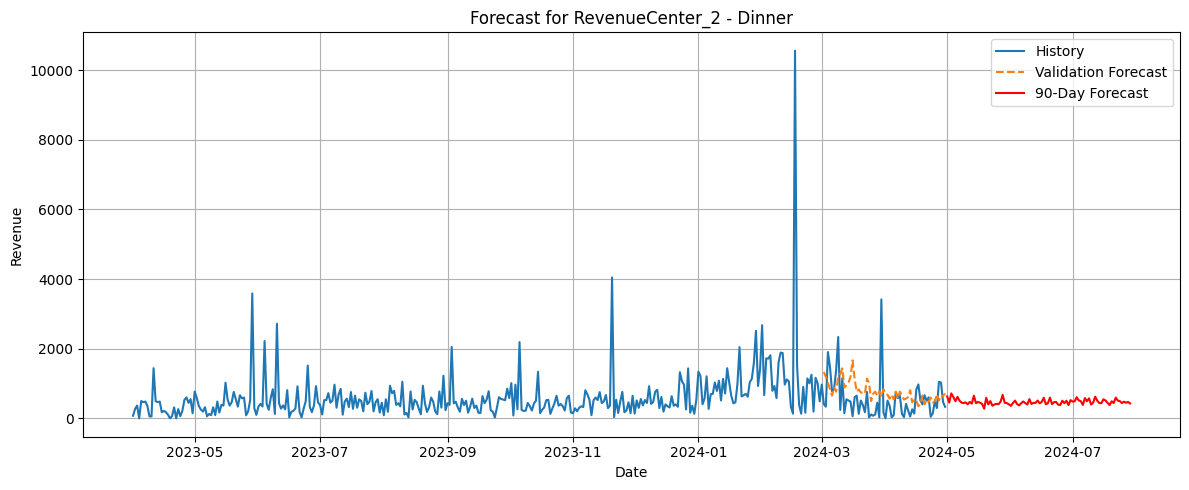

RevenueCenter_2 - Lunch | MAE: 448.23, MAPE: 2292.12%


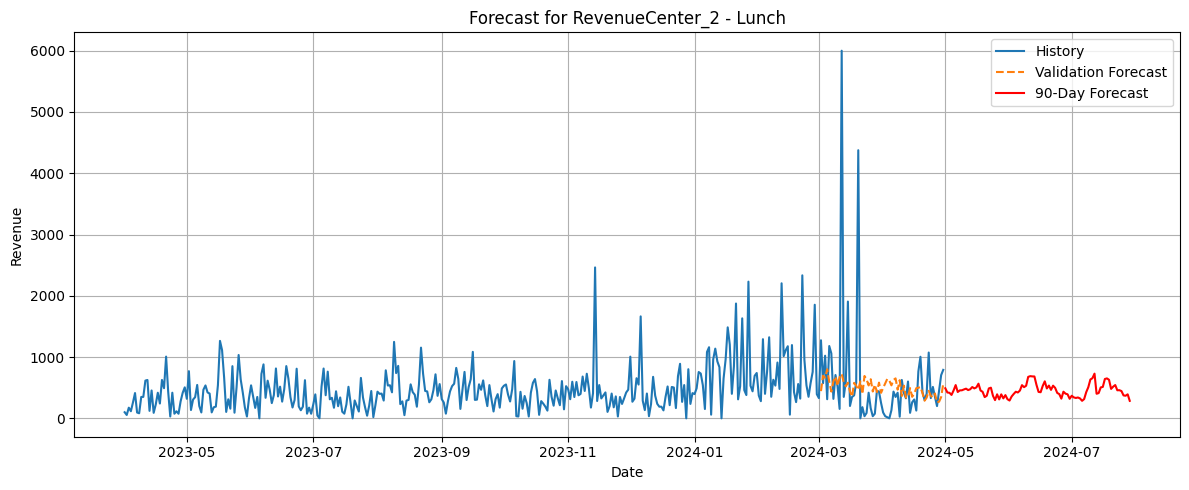

RevenueCenter_2 - BreakFast | MAE: 307.40, MAPE: 3785.72%


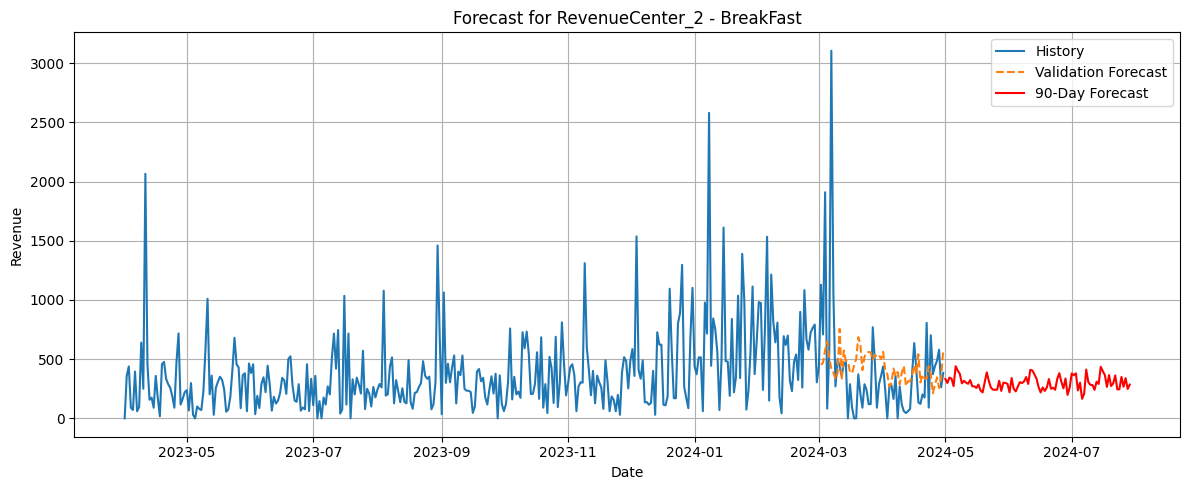

RevenueCenter_3 - Dinner | MAE: 5955.90, MAPE: 66.83%


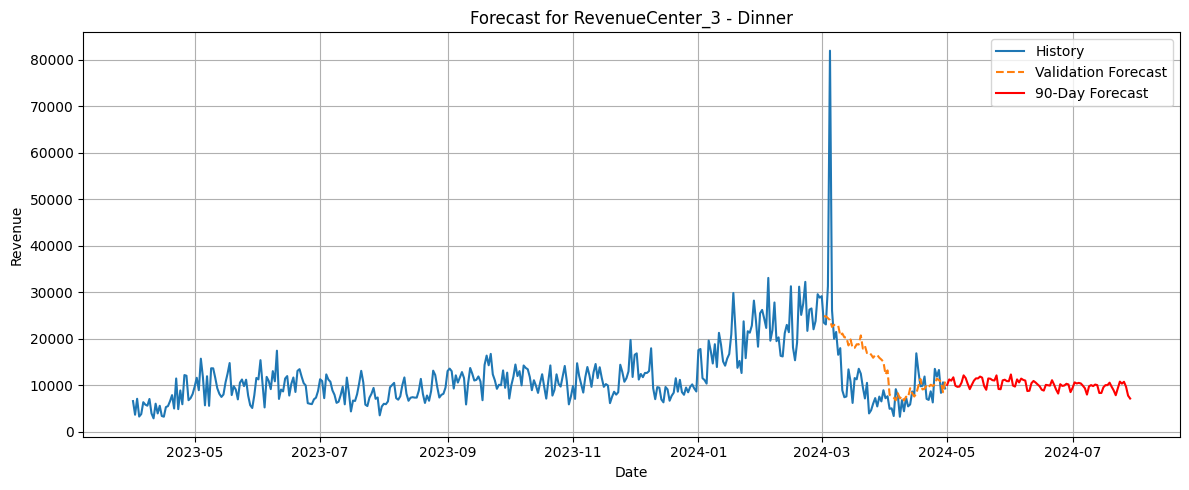

RevenueCenter_3 - Lunch | MAE: 1053.17, MAPE: 85.06%


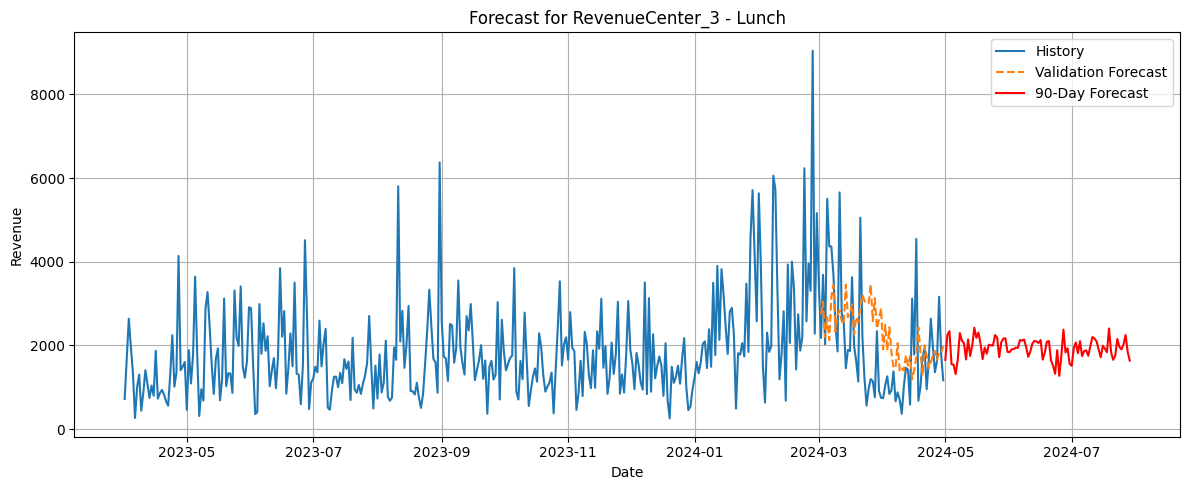

RevenueCenter_3 - BreakFast | MAE: 205.93, MAPE: 1544.11%


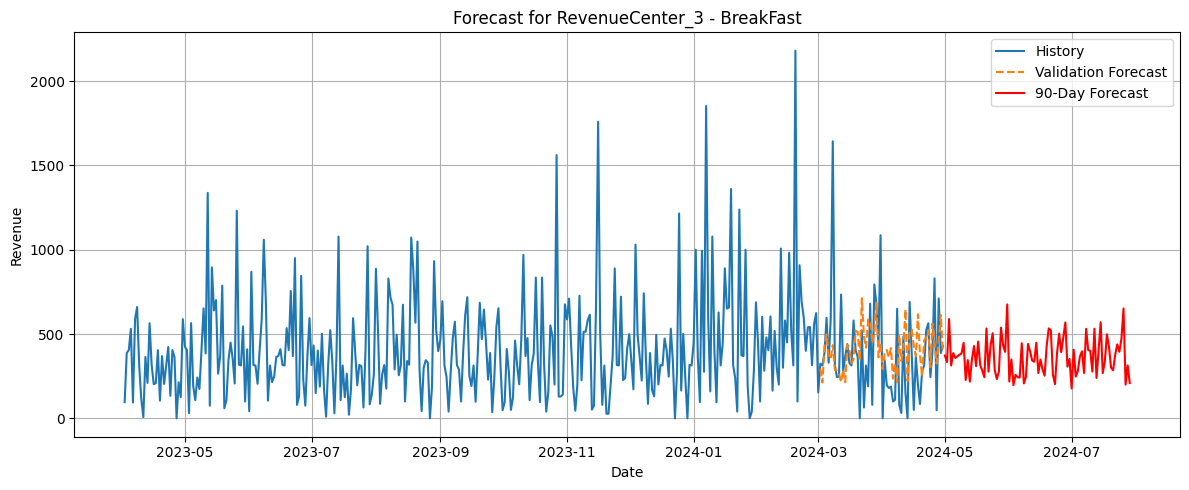

RevenueCenter_4 - Dinner | MAE: 0.00, MAPE: 0.00%


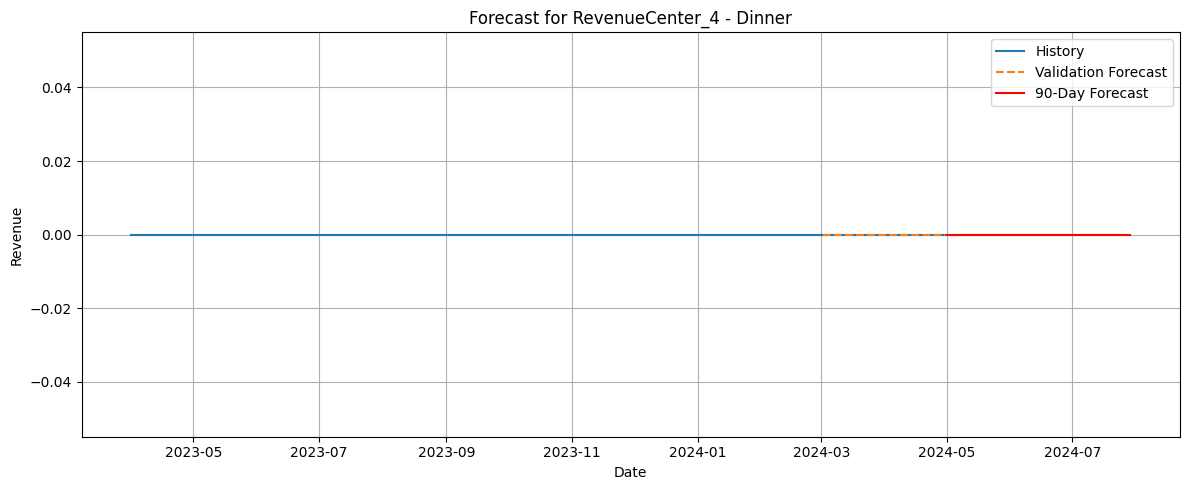

RevenueCenter_4 - Lunch | MAE: 0.00, MAPE: 0.00%


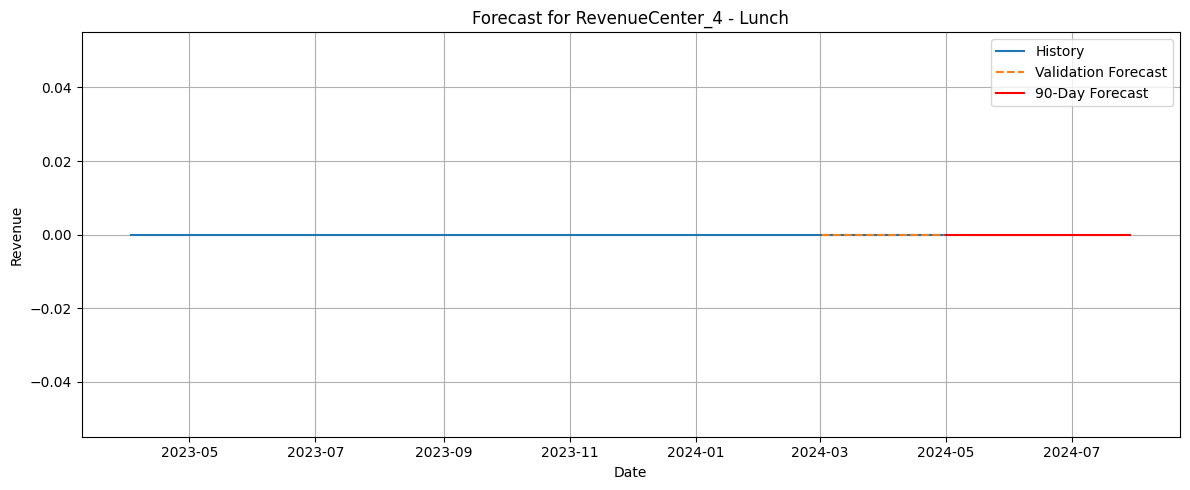

RevenueCenter_4 - BreakFast | MAE: 0.00, MAPE: 0.00%


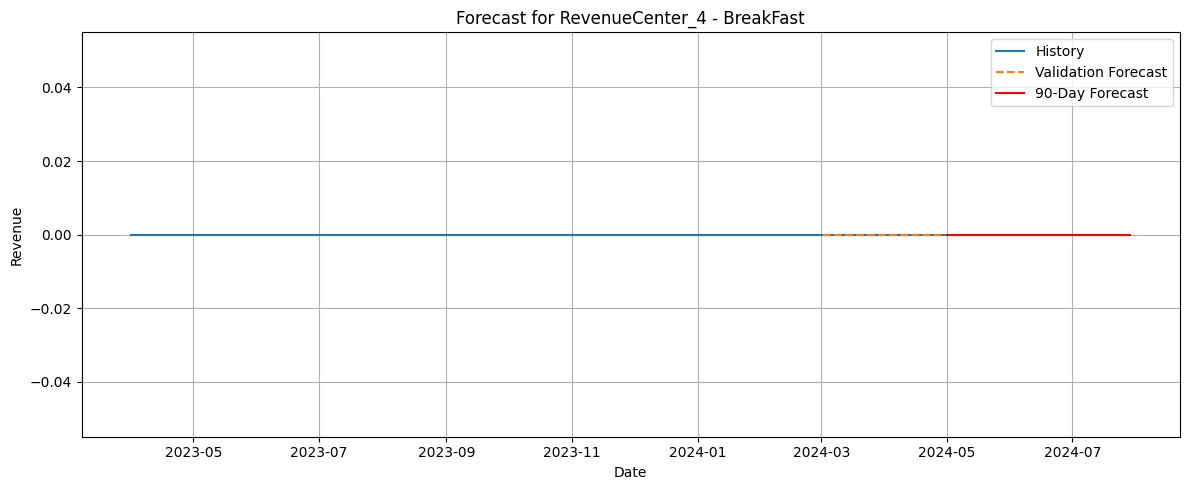

RevenueCenter_5 - Dinner | MAE: 5762.39, MAPE: 67.67%


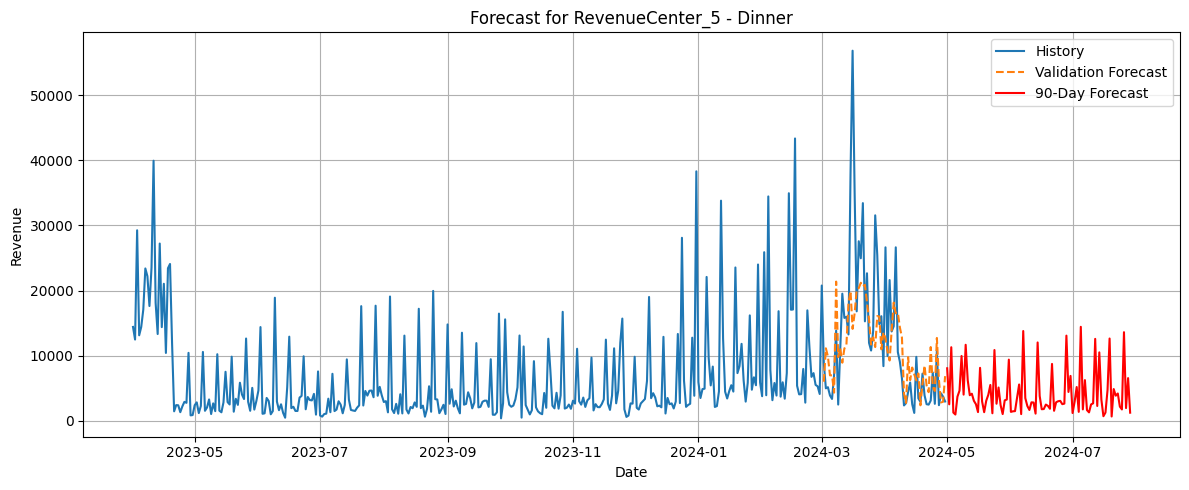

RevenueCenter_5 - Lunch | MAE: 2204.31, MAPE: 3470.07%


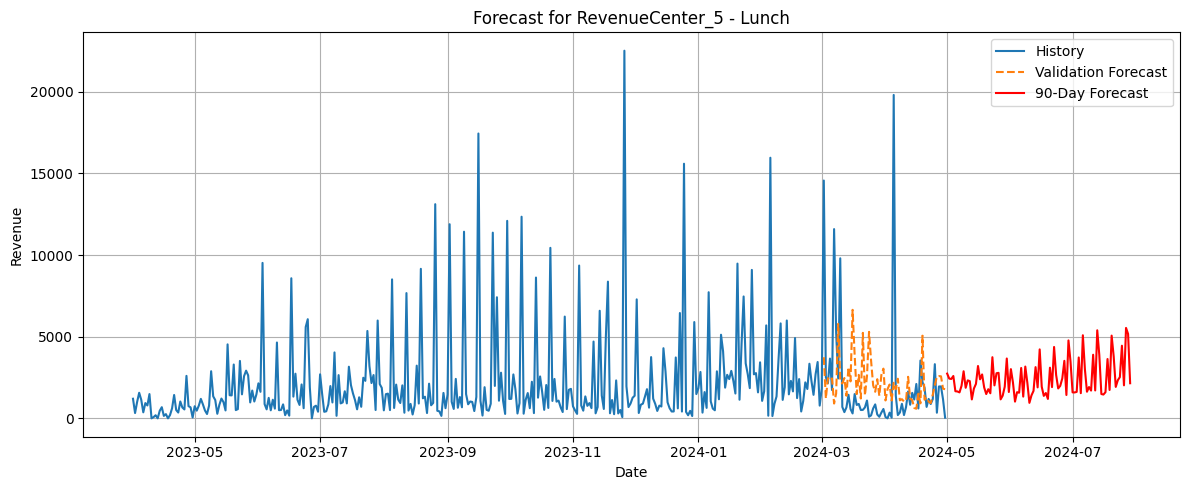

RevenueCenter_5 - BreakFast | MAE: 5154.74, MAPE: 35.19%


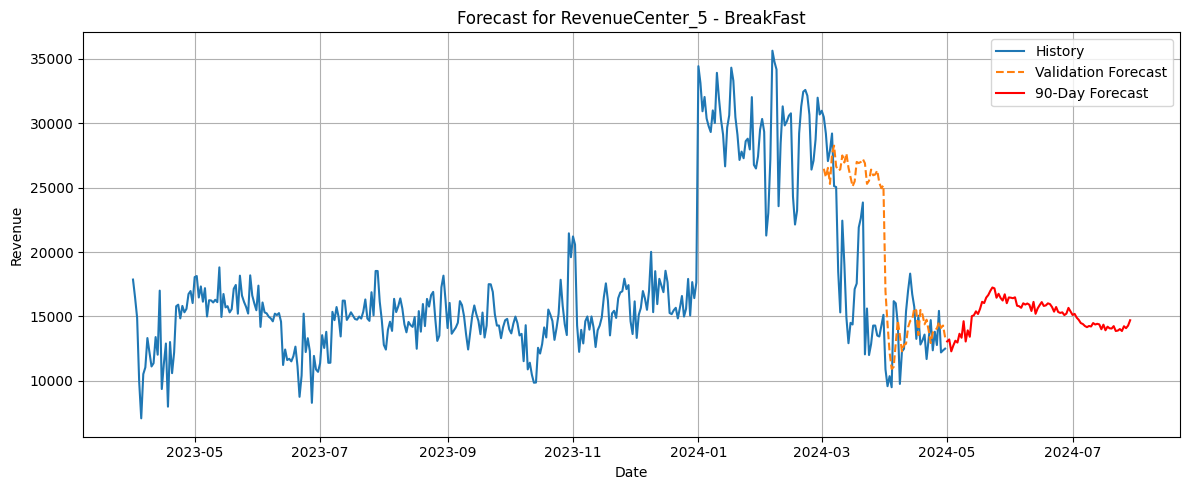

RevenueCenter_6 - Dinner | MAE: 784.18, MAPE: 7644.10%


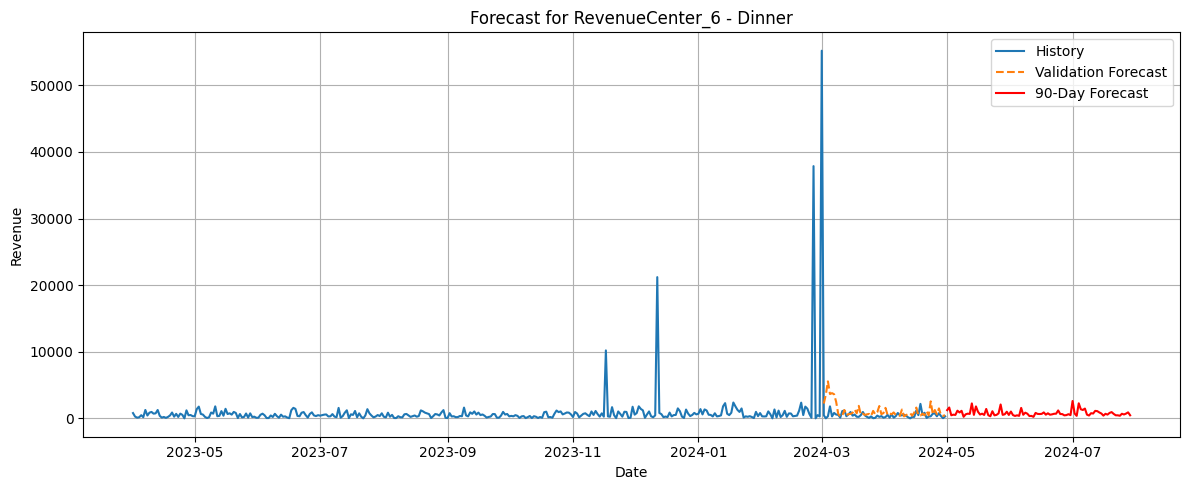

RevenueCenter_6 - Lunch | MAE: 343.81, MAPE: 710.95%


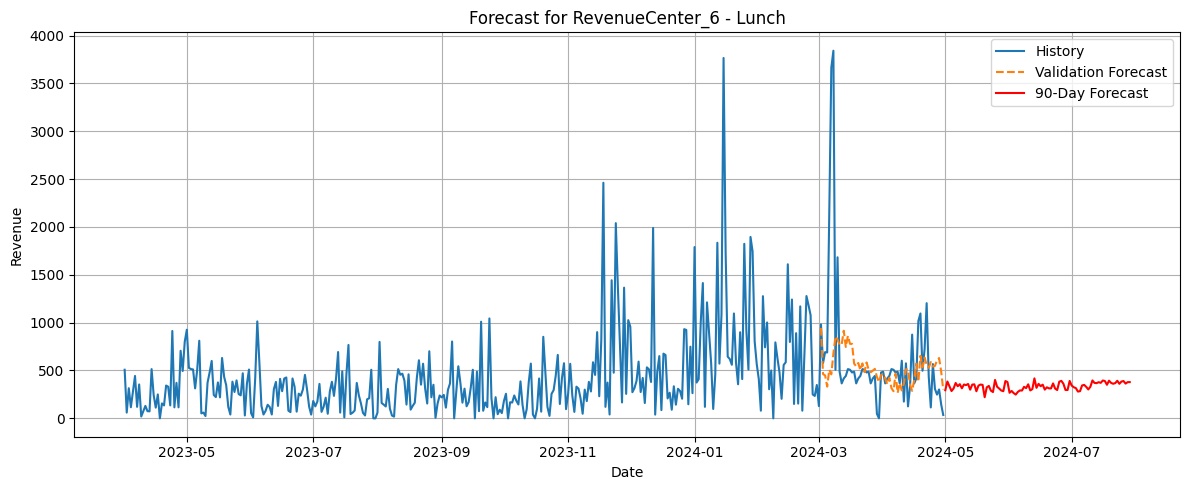

RevenueCenter_6 - BreakFast | MAE: 162.10, MAPE: 1127.31%


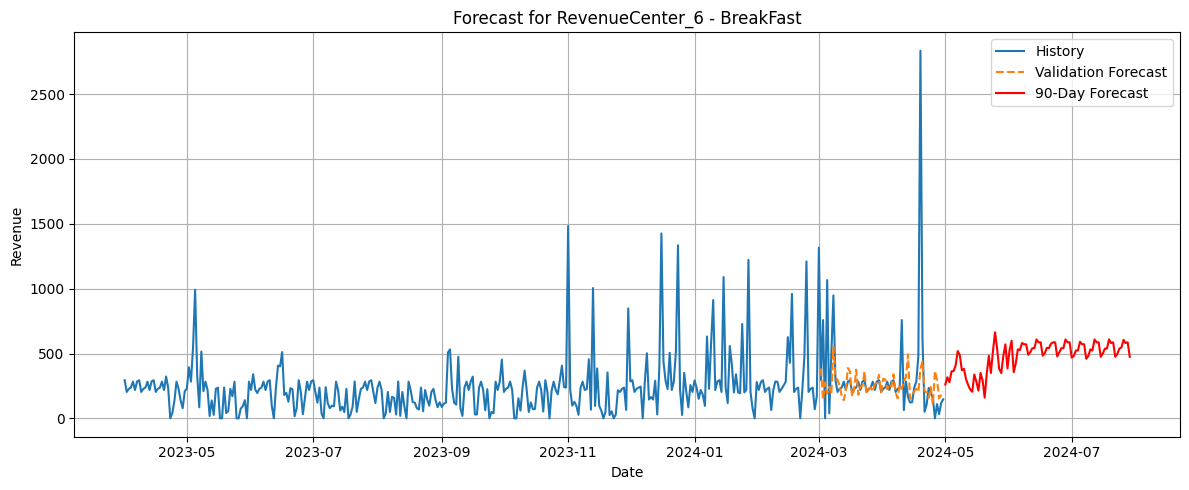

RevenueCenter_7 - Dinner | MAE: 90.64, MAPE: 198.99%


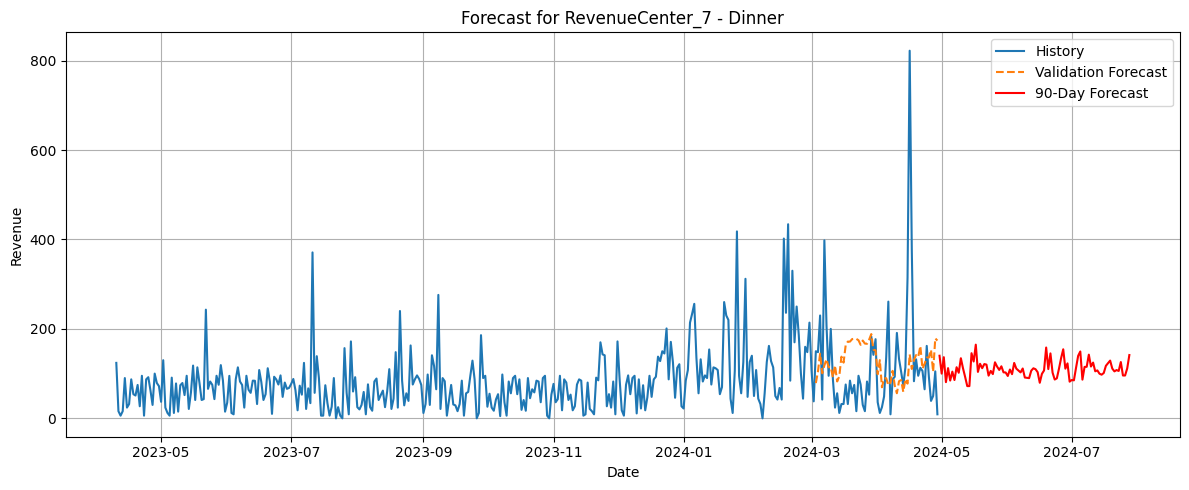

RevenueCenter_7 - Lunch | MAE: 35.18, MAPE: 256.66%


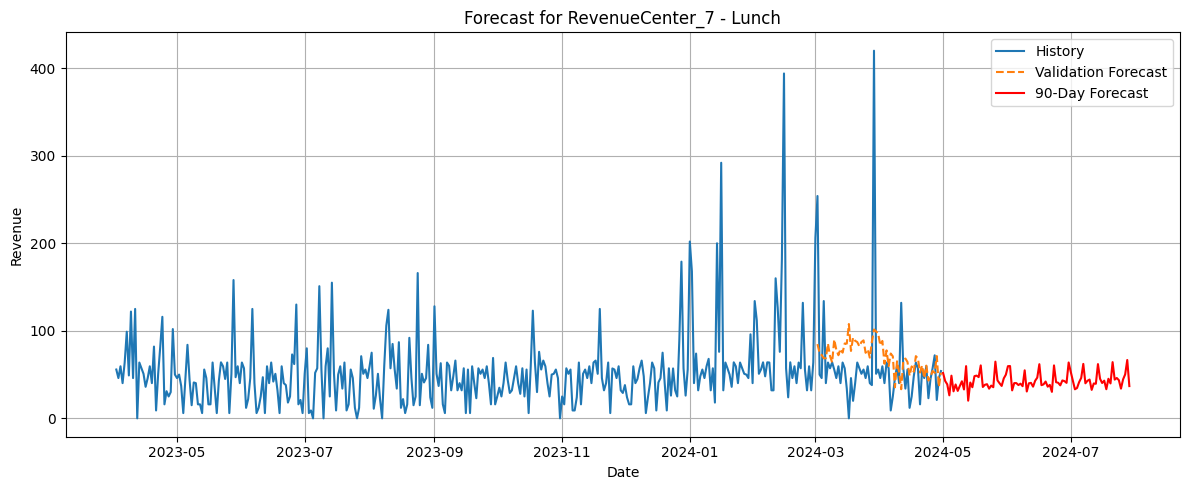

RevenueCenter_7 - BreakFast | MAE: 20.97, MAPE: 198.63%


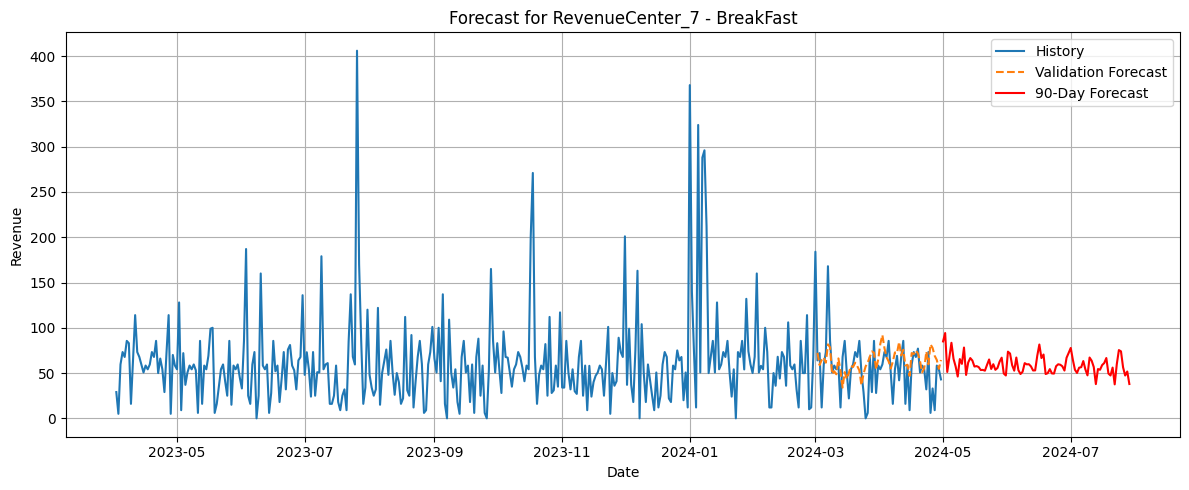

RevenueCenter_8 - Dinner | MAE: 15259.55, MAPE: 62626.61%


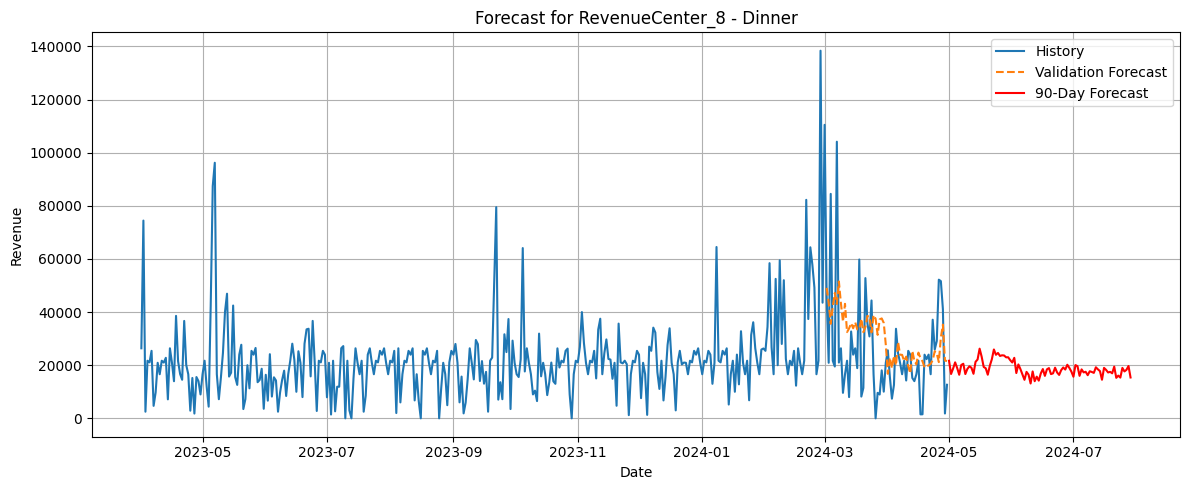

RevenueCenter_8 - Lunch | MAE: 8528.68, MAPE: 18111.05%


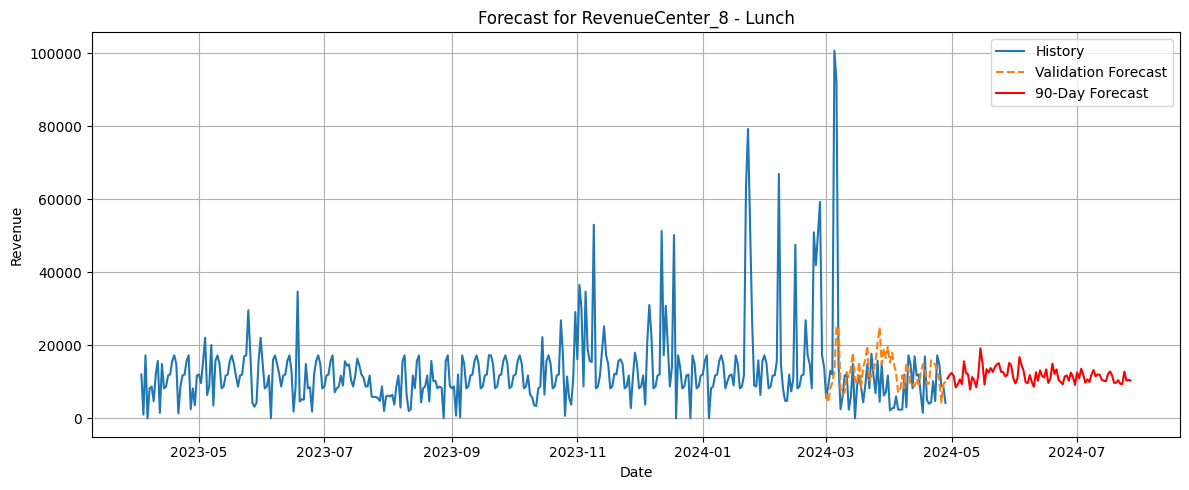

RevenueCenter_8 - BreakFast | MAE: 920.44, MAPE: 14.13%


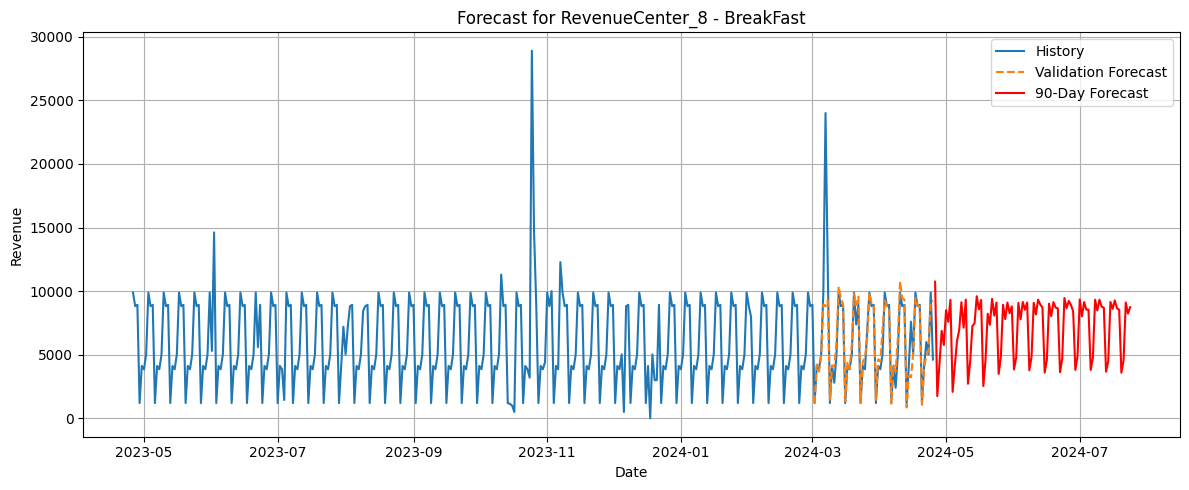

RevenueCenter_9 - Dinner | MAE: 88.53, MAPE: 2075.14%


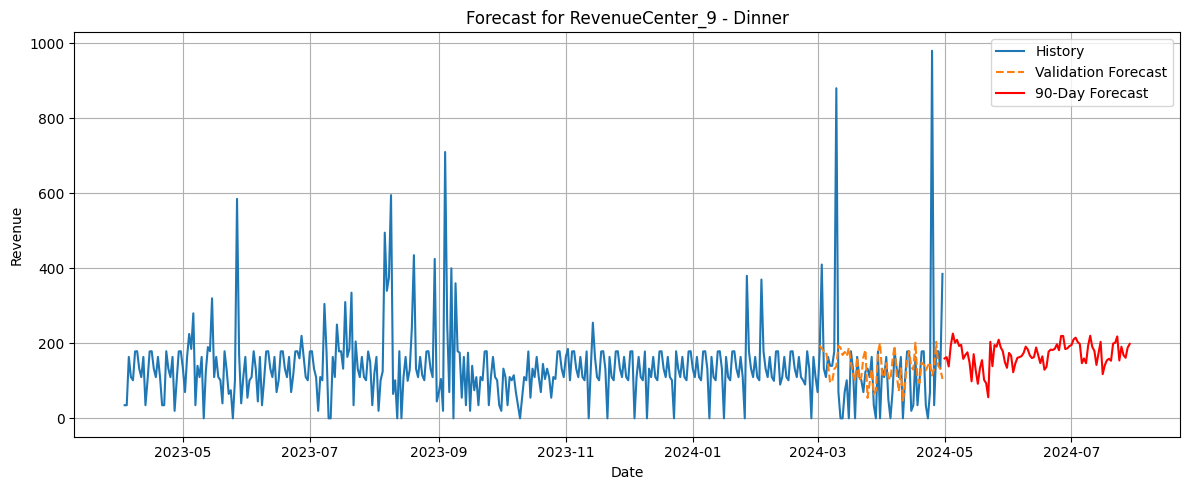

RevenueCenter_9 - Lunch | MAE: 133.24, MAPE: 813.00%


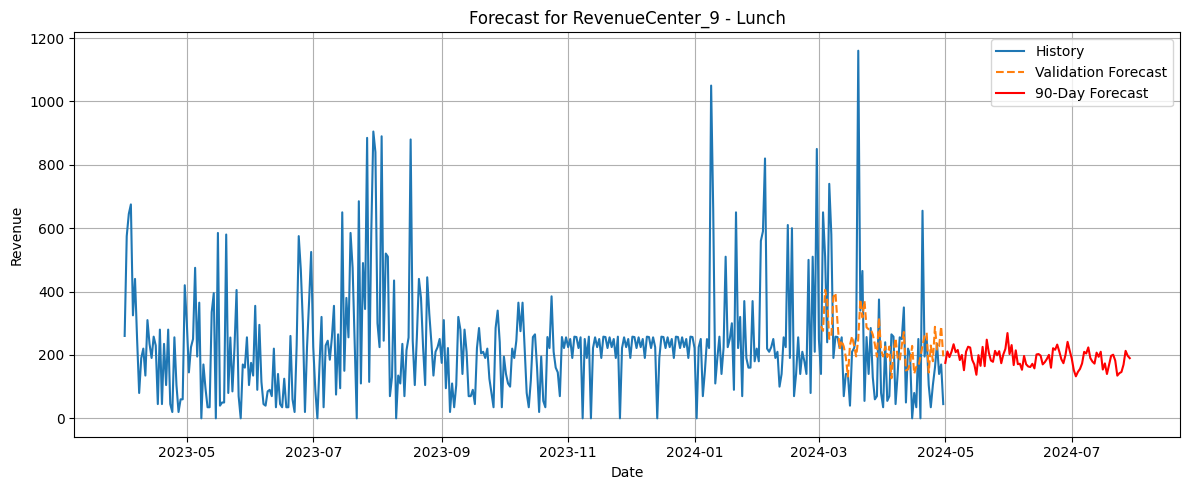

RevenueCenter_9 - BreakFast | MAE: 218.70, MAPE: 318.67%


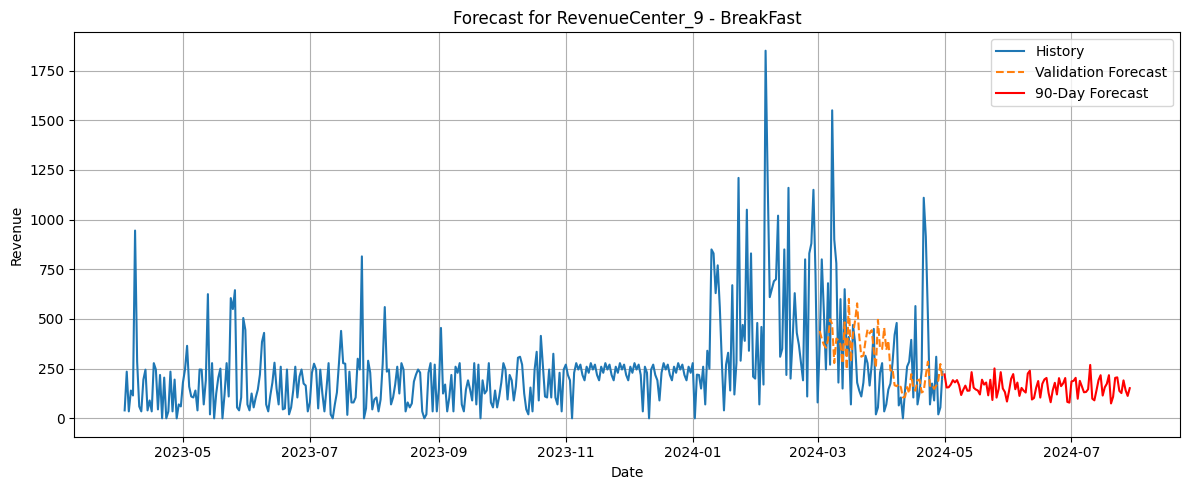

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from datetime import timedelta
import holidays
from hijri_converter import convert
import warnings
warnings.filterwarnings("ignore")

# --- CONFIG ---
DATA_PATH = "/content/Hotel_Revenue_Data.xlsx"
TEST_RATIO = 0.15
LAGS = [1, 2, 3, 7, 14, 28, 35, 60, 90]
uae_hols = holidays.country_holidays("AE", years=range(2010, 2026))

events = {
    "Dubai_Shopping_Festival": pd.date_range("2023-12-15", "2024-01-31"),
    "GITEX_Global": pd.date_range("2024-10-13", "2024-10-17"),
    "Arabian_Travel_Market": pd.date_range("2024-05-06", "2024-05-09"),
    "Dubai_Food_Festival": pd.date_range("2024-05-02", "2024-05-12")
}

def get_ramadan_flag(date):
    try:
        hijri = convert.Gregorian(date.year, date.month, date.day).to_hijri()
        return 1 if hijri.month == 9 else 0
    except:
        return 0

def dubai_temp(date):
    if date.month in [6,7,8]: return 0.9
    elif date.month in [12,1,2]: return 0.4
    else: return 0.6

# --- LOAD DATA ---
df = pd.read_excel(DATA_PATH, parse_dates=["Date"])
df.rename(columns={"MealPeriod": "Meal Period", "CheckTotal": "Check Total", "RevenueCenterName": "Revenue Center"}, inplace=True)

all_centers = df["Revenue Center"].unique()
all_meals = df["Meal Period"].unique()
forecast_results = {}

for center in all_centers:
    for meal in all_meals:
        df_filtered = df[(df["Revenue Center"] == center) & (df["Meal Period"] == meal)]
        if len(df_filtered) < 100: continue  # skip sparse data

        dfg = df_filtered.groupby("Date")["Check Total"].sum().reset_index()
        full_date_range = pd.date_range(start=dfg["Date"].min(), end=dfg["Date"].max(), freq="D")
        dfg = dfg.set_index("Date").reindex(full_date_range).rename_axis("Date").reset_index()

        dow_avg = dfg.groupby(dfg["Date"].dt.dayofweek)["Check Total"].mean()
        dfg["dow_avg"] = dfg["Date"].dt.dayofweek.map(dow_avg)
        dfg["Check Total"] = dfg["Check Total"].fillna(dfg["dow_avg"])
        dfg.drop(columns="dow_avg", inplace=True)

        dfg["DayOfWeek"] = dfg["Date"].dt.dayofweek
        dfg["IsWeekend"] = dfg["DayOfWeek"].isin([5,6]).astype(int)
        dfg["Month"] = dfg["Date"].dt.month
        dfg["DayOfMonth"] = dfg["Date"].dt.day
        dfg["Quarter"] = dfg["Date"].dt.quarter

        for lag in LAGS:
            dfg[f"lag_{lag}"] = dfg["Check Total"].shift(lag)

        dfg["rolling_mean_7"] = dfg["Check Total"].shift(1).rolling(7).mean()
        dfg["rolling_mean_28"] = dfg["Check Total"].shift(1).rolling(28).mean()
        dfg["rolling_std_7"] = dfg["Check Total"].shift(1).rolling(7).std().fillna(0)

        dfg["Holiday"] = dfg["Date"].isin(uae_hols).astype(int)
        dfg["Pre_Holiday"] = dfg["Date"].shift(-1).isin(uae_hols).astype(int)
        dfg["Post_Holiday"] = dfg["Date"].shift(1).isin(uae_hols).astype(int)

        dfg["Event_Impact"] = 1.0
        for event, dates in events.items():
            dfg.loc[dfg["Date"].isin(dates), "Event_Impact"] = 1.5

        dfg["Ramadan"] = dfg["Date"].apply(get_ramadan_flag)
        dfg["Temp_Proxy"] = dfg["Date"].apply(dubai_temp)
        dfg = dfg.dropna(subset=[f"lag_{max(LAGS)}"]).reset_index(drop=True)

        FEATURES = [f"lag_{lag}" for lag in LAGS] + [
            "DayOfWeek", "IsWeekend", "Month", "DayOfMonth", "Quarter",
            "rolling_mean_7", "rolling_mean_28", "rolling_std_7",
            "Holiday", "Pre_Holiday", "Post_Holiday",
            "Ramadan", "Event_Impact", "Temp_Proxy"
        ]
        TARGET = "Check Total"

        split_idx = int((1 - TEST_RATIO) * len(dfg))
        train_df, valid_df = dfg.iloc[:split_idx], dfg.iloc[split_idx:]

        X_train, y_train = train_df[FEATURES].values, train_df[TARGET].values
        X_val, y_val = valid_df[FEATURES].values, valid_df[TARGET].values

        dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=FEATURES)
        dval = xgb.DMatrix(X_val, label=y_val, feature_names=FEATURES)

        model = xgb.train(
            {
                "objective": "reg:squarederror", "eval_metric": "mae",
                "max_depth": 4, "eta": 0.03, "subsample": 0.8,
                "colsample_bytree": 0.7, "gamma": 0.5,
                "min_child_weight": 10, "alpha": 0.5, "lambda": 1.0, "seed": 42
            },
            dtrain,
            num_boost_round=800,
            evals=[(dtrain, "train"), (dval, "val")],
            early_stopping_rounds=20,
            verbose_eval=False
        )

        y_pred = model.predict(dval)
        mae = mean_absolute_error(y_val, y_pred)
        mape = np.mean(np.abs((y_val - y_pred) / np.maximum(y_val, 1))) * 100

        print(f"{center} - {meal} | MAE: {mae:.2f}, MAPE: {mape:.2f}%")

        # Forecast 90 Days
        full_history = dfg.copy().set_index("Date")["Check Total"]
        future_dates = pd.date_range(dfg["Date"].iloc[-1] + timedelta(days=1), periods=90)
        forecast_values = []

        for date in future_dates:
            f = {
                "DayOfWeek": date.dayofweek,
                "IsWeekend": int(date.dayofweek >= 5),
                "Month": date.month,
                "DayOfMonth": date.day,
                "Quarter": (date.month - 1) // 3 + 1,
                "Holiday": int(date in uae_hols),
                "Pre_Holiday": int((date + timedelta(days=1)) in uae_hols),
                "Post_Holiday": int((date - timedelta(days=1)) in uae_hols),
                "Ramadan": get_ramadan_flag(date),
                "Temp_Proxy": dubai_temp(date),
                "Event_Impact": 1.5 if any(date in d for d in events.values()) else 1.0
            }
            for lag in LAGS:
                lag_date = date - timedelta(days=lag)
                f[f"lag_{lag}"] = full_history.get(lag_date, full_history.iloc[-lag])
            f["rolling_mean_7"] = full_history.iloc[-7:].mean()
            f["rolling_mean_28"] = full_history.iloc[-28:].mean()
            f["rolling_std_7"] = full_history.iloc[-7:].std()
            dmat = xgb.DMatrix(np.array([f[col] for col in FEATURES]).reshape(1, -1), feature_names=FEATURES)
            forecast = model.predict(dmat)[0]
            full_history.loc[date] = forecast
            forecast_values.append(forecast)

        # Save to dictionary
        forecast_results[(center, meal)] = pd.DataFrame({
            "Date": future_dates,
            "Forecast": forecast_values
        })

        # Plot
        plt.figure(figsize=(12, 5))
        plt.plot(dfg["Date"], dfg["Check Total"], label="History")
        plt.plot(valid_df["Date"], y_pred, label="Validation Forecast", linestyle="--")
        plt.plot(future_dates, forecast_values, "r-", label="90-Day Forecast")
        plt.title(f"Forecast for {center} - {meal}")
        plt.xlabel("Date")
        plt.ylabel("Revenue")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
